## Prototypical Network

In [15]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from collections import defaultdict
from torchvision.datasets import ImageFolder, CIFAR100
import numpy as np
import lightning as L
import matplotlib.pyplot as plt
import torchvision
from torchvision.models import resnet18
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average
from tqdm import tqdm


import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_root not in sys.path:
    sys.path.append(project_root)
    
from model_utils import no_augmentation, ClassificationData



100%|██████████| 169M/169M [00:07<00:00, 22.1MB/s] 


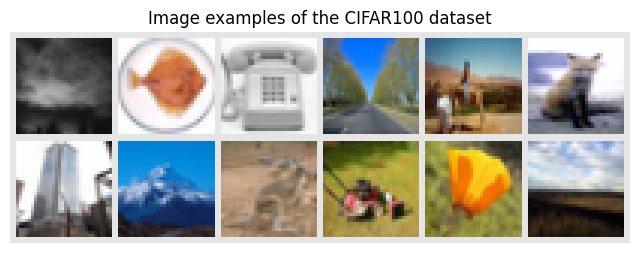

In [2]:
cifar_train_set = CIFAR100(root="C:/Users/SPCX/Downloads", train=True, download=True, transform=torchvision.transforms.ToTensor())
NUM_IMAGES = 12
cifar_images = [cifar_train_set[np.random.randint(len(cifar_train_set))][0] for idx in range(NUM_IMAGES)]
cifar_images = torch.stack(cifar_images, dim=0)
img_grid = torchvision.utils.make_grid(cifar_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the CIFAR100 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()

In [4]:
cifar_train_set.data.shape

(50000, 32, 32, 3)

In [2]:
class ImageDataset(Dataset):
    def __init__(self, imgs, targets, img_transform=no_augmentation):
        """
        Inputs:
            imgs - Numpy array of shape [N,32,32,3] containing all images.
            targets - PyTorch array of shape [N] containing all labels.
            img_transform - A torchvision transformation that should be applied
                            to the images before returning. If none, no transformation
                            is applied.
        """
        super().__init__()
        self.img_transform = img_transform
        self.imgs = imgs
        self.targets = targets

    def __getitem__(self, idx):
        img, target = self.imgs[idx], self.targets[idx]
        img = Image.fromarray(img)

        if self.img_transform is not None:
            img = self.img_transform(img)

        return img, target

    def __len__(self):
        return self.imgs.shape[0]

In [3]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor()
])

train_set = ImageFolder("../data_subset/train", transform=data_transform)
val_set = ImageFolder("../data_subset/valid", transform=data_transform)
test_set = ImageFolder("../data_subset/test_proto", transform=data_transform)

train_images = np.array([img.numpy().transpose(1, 2, 0) for img, _ in train_set])
val_images = np.array([img.numpy().transpose(1, 2, 0) for img, _ in val_set])
test_images = np.array([img.numpy().transpose(1, 2, 0) for img, _ in test_set])
print(f"Shape of train images: {train_images.shape}")
print(f"Shape of val images: {val_images.shape}")
print(f"Shape of test images: {test_images.shape}")

all_images = np.concatenate([train_images, val_images, test_images], axis=0)
all_targets = torch.LongTensor(train_set.targets + val_set.targets + test_set.targets)

print(f"Shape of all images: {all_images.shape}")
L.seed_everything(0)
classes = torch.randperm(10)
train_classes, val_classes, test_classes = classes[:4], classes[4:7], classes[7:]


Seed set to 0


Shape of train images: (10000, 32, 32, 3)
Shape of val images: (10000, 32, 32, 3)
Shape of test images: (10000, 32, 32, 3)
Shape of all images: (30000, 32, 32, 3)


In [4]:
def split_batch(imgs, targets):
    support_imgs, query_imgs = imgs.chunk(2, dim=0)
    support_targets, query_targets = targets.chunk(2, dim=0)
    return support_imgs, query_imgs, support_targets, query_targets

In [4]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """

        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all support features vector with label i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        scores = -dists
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()

model = PrototypicalNetworks(convolutional_network).cuda()

c:\Users\SPCX\Desktop\github-repositories\dl-cnn\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SPCX\Desktop\github-repositories\dl-cnn\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
N_WAY = 5 # Number of classes in a task
N_SHOT = 5 # Number of images per class in the support set
N_QUERY = 10 # Number of images per class in the query set
N_EVALUATION_TASKS = 100

In [12]:
test_set.labels = [
    test_set.targets[i] for i in range(len(test_set.targets))
]

def get_labels(self):
    return self.labels
test_set.get_labels = get_labels.__get__(test_set, ImageDataset)


test_sampler = TaskSampler(
    test_set, 
    n_way=N_WAY, 
    n_shot=N_SHOT, 
    n_query=N_QUERY, 
    n_tasks=N_EVALUATION_TASKS,
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=0,
    collate_fn=test_sampler.episodic_collate_fn,
)

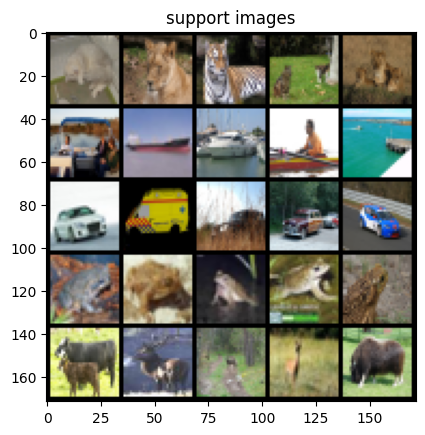

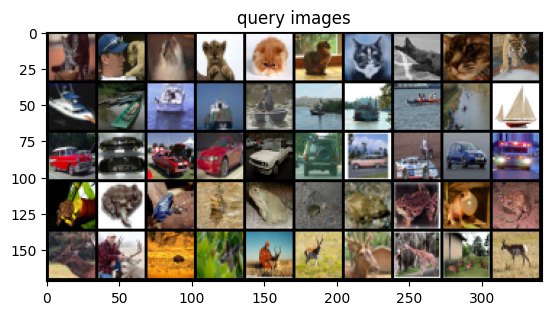

In [14]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [16]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total 
    number of predictions.
    """
    return (
        torch.max(
            model(
                support_images.cuda(), 
                support_labels.cuda(), 
                query_images.cuda(),
            )
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

100%|██████████| 100/100 [00:03<00:00, 28.19it/s]

Model tested on 100 tasks. Accuracy: 39.72%


In [19]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

train_set.labels = [
    train_set.targets[i] for i in range(len(train_set.targets))
]
train_set.get_labels = get_labels.__get__(train_set, ImageDataset)

train_sampler = TaskSampler(
    train_set, 
    n_way=N_WAY, 
    n_shot=N_SHOT, 
    n_query=N_QUERY, 
    n_tasks=N_TRAINING_EPISODES,
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=0,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [21]:
log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(
            support_images, 
            support_labels, 
            query_images, 
            query_labels,
        )
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(
                loss=sliding_average(all_loss, log_update_frequency)
            )

100%|██████████| 40000/40000 [23:18<00:00, 28.61it/s, loss=0.00675]


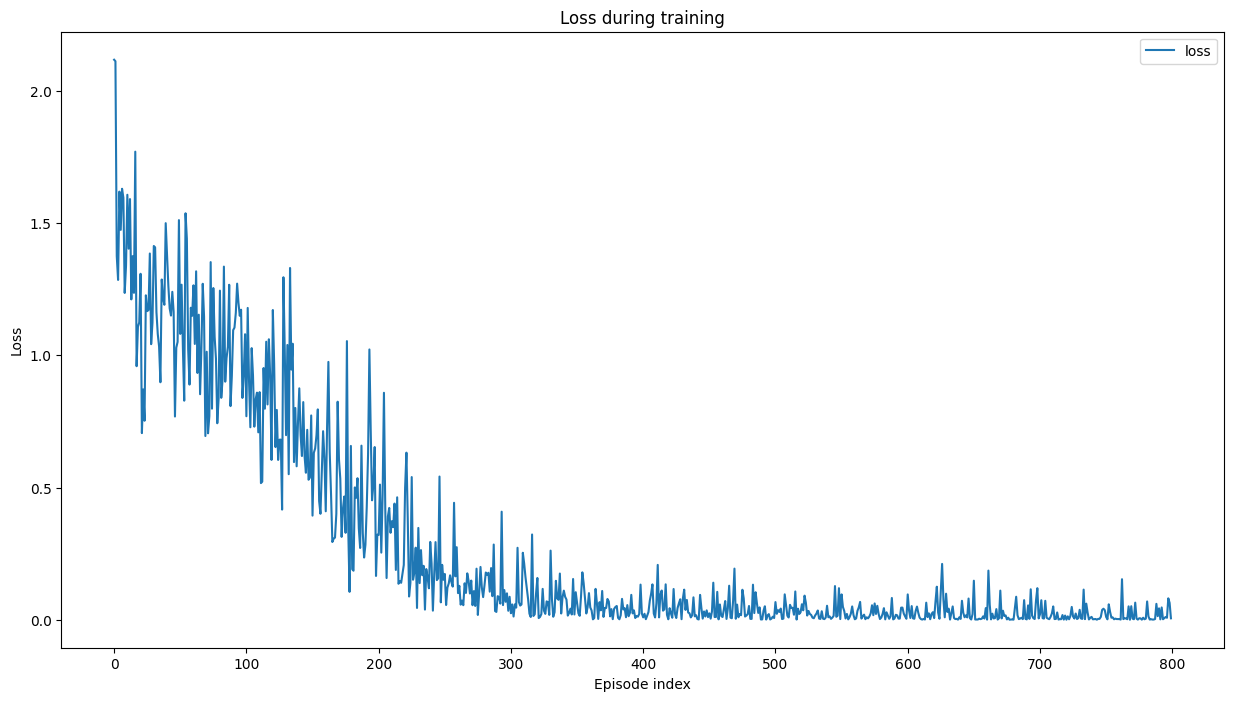

In [26]:
# plot all_loss
plt.figure(figsize=(15, 8))
plt.plot(all_loss[::50], label="loss")
plt.xlabel("Episode index")
plt.ylabel("Loss")
plt.title("Loss during training")
plt.legend()
plt.show()

In [28]:
all_loss[-1]

0.0009640779462642968

In [27]:
evaluate(test_loader)

100%|██████████| 100/100 [00:02<00:00, 41.96it/s]

Model tested on 100 tasks. Accuracy: 55.38%


This notebook is based on code described [here](https://data-ai.theodo.com/en/technical-blog/your-few-shot-model-15mn-pytorch).

It is adjusted for the latest version of imported libraries and to run on any image dataset.